# Language abstraction analysis notebook

This notebook collects analyses performed for the LAX cogsci 2022 paper.

Statistics were largely done outside of this notebook, in R (see lax_corpus_statistics.Rmd and mixed-effects-model.Rmd in this folder).

### setup

In [1]:
subdomains = {
    'structures' :  ['bridge','city','house','castle'],
    'drawing' :  ['nuts-bolts','wheels','dials','furniture']
}

domains = list(subdomains.keys())

In [2]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../../stimuli")

import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as distance
import pandas as pd

from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageColor

from io import BytesIO
import base64

import random
import  matplotlib
from matplotlib import pylab, mlab, pyplot
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

from IPython.display import clear_output, Image, HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import spacy
nlp = spacy.load("en_core_web_lg")
# sys.path.append("../../stimuli/towers/block_utils/")
# import blockworld_utils as utils

In [3]:
# styling for paper_figures

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

LIGHT_BLUE = "#56B0CD"
LIGHT_ORANGE = "#FFCE78"
LIGHT_GREEN = "#95C793"
LIGHT_RED = "#CC867A"

BLUE = "#009BCD"
ORANGE = "#FFA300"
GREEN = "#688B67"
RED = "#CC5945"

DARK_BLUE   = "#0E4478"
DARK_ORANGE = "#A46400"
DARK_GREEN  = "#275C4A"
DARK_RED    =  "#9B3024"

domain_palettes_light = {
    
    domains[0]:{
        subdomains[domains[0]][0]: LIGHT_BLUE,
        subdomains[domains[0]][1]: LIGHT_ORANGE,
        subdomains[domains[0]][2]: LIGHT_GREEN, 
        subdomains[domains[0]][3]: LIGHT_RED   
    },
     domains[1]:{
        subdomains[domains[1]][0]: LIGHT_BLUE,
        subdomains[domains[1]][1]: LIGHT_ORANGE,
        subdomains[domains[1]][2]: LIGHT_GREEN, 
        subdomains[domains[1]][3]: LIGHT_RED 
    }
}

domain_palettes = {
    
    domains[0]:{
        subdomains[domains[0]][0]: BLUE,
        subdomains[domains[0]][1]: ORANGE,
        subdomains[domains[0]][2]: GREEN,
        subdomains[domains[0]][3]: RED
    },
     domains[1]:{
        subdomains[domains[1]][0]: BLUE,
        subdomains[domains[1]][1]: ORANGE,
        subdomains[domains[1]][2]: GREEN,
        subdomains[domains[1]][3]: RED
    }
}

domain_palettes_dark = {
    
    domains[0]:{
        subdomains[domains[0]][0]: DARK_BLUE,
        subdomains[domains[0]][1]: DARK_ORANGE,
        subdomains[domains[0]][2]: DARK_GREEN, 
        subdomains[domains[0]][3]: DARK_RED   
    },
     domains[1]:{
        subdomains[domains[1]][0]: DARK_BLUE,
        subdomains[domains[1]][1]: DARK_ORANGE,
        subdomains[domains[1]][2]: DARK_GREEN, 
        subdomains[domains[1]][3]: DARK_RED 
    }
}

N=256
gradients = []

for light, mid, dark in zip([LIGHT_BLUE,LIGHT_ORANGE,LIGHT_GREEN,LIGHT_RED],[BLUE,ORANGE,GREEN,RED],[DARK_BLUE,DARK_ORANGE,DARK_GREEN,DARK_RED]):
    light_rgb = list(ImageColor.getcolor(light, "RGB"))
    mid_rgb = list(ImageColor.getcolor(mid, "RGB"))
    dark_rgb = list(ImageColor.getcolor(dark, "RGB"))
    vals = np.ones((N, 4))
    vals[:, 0] = np.append(np.linspace(light_rgb[0]/255, mid_rgb[0]/255, int(N/2)),np.linspace(mid_rgb[0]/255, dark_rgb[0]/255, int(N/2))) # R
    vals[:, 1] = np.append(np.linspace(light_rgb[1]/255, mid_rgb[1]/255, int(N/2)),np.linspace(mid_rgb[1]/255, dark_rgb[1]/255, int(N/2))) # G
    vals[:, 2] = np.append(np.linspace(light_rgb[2]/255, mid_rgb[2]/255, int(N/2)),np.linspace(mid_rgb[2]/255, dark_rgb[2]/255, int(N/2))) # B
    newcmp = ListedColormap(vals)
    
    gradients.append(newcmp)

domain_gradients = {

    domains[0]:{
        subdomains[domains[0]][0]: gradients[0],
        subdomains[domains[0]][1]: gradients[1],
        subdomains[domains[0]][2]: gradients[2],
        subdomains[domains[0]][3]: gradients[3],
    },
     domains[1]:{
        subdomains[domains[1]][0]: gradients[0],
        subdomains[domains[1]][1]: gradients[1],
        subdomains[domains[1]][2]: gradients[2],
        subdomains[domains[1]][3]: gradients[3],
    }
}


In [4]:
def add_numbers_and_space(responses):
    responses = [f"{id}: {response}" for (id, response) in enumerate(responses)]
    responses = '\n'.join(responses)
    return responses

def group_by_stim_url(df, config_name):
    df[config_name] = df[['stimURL','responses']].groupby(['stimURL'])['responses'].transform(lambda responses: add_numbers_and_space(responses))
    df[['stimURL', config_name]].drop_duplicates()
    return df[['stimURL', config_name]]

def group_by_stim_id(df, config_name):
    df[config_name] = df[['stimId','responses']].groupby(['stimId'])['responses'].transform(lambda responses: add_numbers_and_space(responses))
    df[['stimId', config_name]].drop_duplicates()
    return df[['stimId', config_name]]

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-width:100px " />'


def stimId_to_s3URL(domain, subdomain, stimID):
    
    if domain == 'structures':
        url =  "https://lax-{}-{}-all.s3.amazonaws.com/".format(domain, 
                                                                subdomain)\
               + "lax-{}-{}-{}-all.png".format(domain,
                                      subdomain,
                                      str(stimID).zfill(3))
    else: #check this
        url =  "https://lax-{}-{}-all.s3.amazonaws.com/".format(domain, 
                                                                subdomain)\
               + "lax-{}-{}-all-{}.png".format(domain,
                                      subdomain,
                                      str(stimID).zfill(3))

    return url
    

def stimId_to_html(stimId, domain = 'structures', subdomain = 'bridge'):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''
    stimURL = stimId_to_s3URL(domain, subdomain, stimId) 
    return '<img src="'+ stimURL + '" style=max-width:150px " />'




### load dataframe

In [5]:
results_csv_directory = "../../results/csv/"
df_trial = pd.read_csv(os.path.join(results_csv_directory, 'lax_corpus_1k_trials_cogsci22.csv'))

### column name descriptions

```
id
'iterationName':internal experiment version id
'config_name': internal experiment id
    
'condition': not used in this experiment
'domain': structures/ drawing
'subdomain':  ['bridge','city','house','castle'], ['nuts-bolts','wheels','dials','furniture']
'gameID': uuid for participant

'rt': reaction time
'rt_mins': reaction time in minutes

'trial_index': jspsych trial number (not experimental)
'trial_type': df_trial contains only annotations
'time_elapsed': 
'complete_dataset': did participant submit 10 responses?
'trial_num': trial number
    
'responses': complete response of what and where messages
'response_lists': same as above, but list of lists
'whats': list of what responses
'wheres': list of where responses
'n_steps': number of steps
'what_messages_lengths': list of lengths of what responses (characters)
'where_messages_lengths': list of lengths of where responses (characters)
'what_char_sum': total characters in what responses
'where_char_sum': total characters in where responses
'char_sum': total characters in responses 
'ppt_hit_8_step_limit': participant was in version of experiment with 8 steps, and hit this limit on at least one trial


'lemmatized_whats': lemmatized by spacy
'lemmatized_wheres':
'lemmatized_notstop_whats': lemmatized by spacy, stop words (incl numbers) removed
'lemmatized_notstop_wheres': 
'lemmatized_filtered_whats': lemmatized by spacy, determiners, punctuation and symbols removed
'lemmatized_filtered_wheres':

``` 

## Preprocessing

For thorough language preprocessing, see `/notebooks/lax-corpus-data-generator.ipynb`

### Common preprocessing

Most preprocessing is dealt with in ./lax_corpus_data_generator.ipynb

Here we add preprocessing steps common to several but not all analyses

In [6]:
# interpret more complex data structures i.e. lists
for column_name in ['responses',
                    'whats',
                    'wheres',
                    'lemmatized_whats',
                    'lemmatized_notstop_whats',
                    'lemmatized_filtered_whats',
                    'lemmatized_wheres',
                    'lemmatized_notstop_wheres',
                    'lemmatized_filtered_wheres',
                    'low_level_parts',
                    'mid_level_parts',
                    'high_level_parts',
                    'low_level_part_types',
                    'mid_level_part_types',
                    'high_level_part_types',
                    'low_level_part_params',
                    'mid_level_part_params',
                    'high_level_part_params',
                    'dreamcoder_program_dsl_0_tokens'
                   ]:
    df_trial[column_name] = df_trial[column_name].apply(ast.literal_eval)


In [7]:
assert df_trial.dreamcoder_program_dsl_0_tokens.apply(lambda x: type(x) == list).all()

df_trial.loc[:,'base_program_length'] = df_trial.dreamcoder_program_dsl_0_tokens.apply(len)

In [8]:
# add mean word count for each stim
what_word_sum_means = df_trial.groupby(['domain','subdomain','stimId']).mean()['what_word_sum'].reset_index()
what_word_sum_means = what_word_sum_means.rename(columns={'what_word_sum':'what_word_mean'})

#add means to df_trial (only do this if you will take one row per item from df_trial)
df_trial = df_trial.merge(what_word_sum_means, how='left', on=['domain','subdomain','stimId']) 

In [9]:
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer

In [10]:
word_to_pos = {}
for _, row in df_trial.iterrows():
    whats_list = row["lemmatized_whats"]
    pos_list = ast.literal_eval(row["whats_pos"])
    for i in range(len(whats_list)):
        item = whats_list[i]
        for j in range(len(item)):
            word = whats_list[i][j]
            pos = pos_list[i][j]
            word_to_pos[word] = pos

In [11]:
# Replace common misspellings (applied to top-word analyses below)
spelling_map = {w: w for w in word_to_pos.keys()}
spelling_map["boarder"] = "border"
spelling_map["centre"] = "center"
spelling_map["cirlce"] = "circle"
spelling_map["cirlcle"] = "circle"
spelling_map["colour"] = "color"
spelling_map["collumn"] = "column"
spelling_map["columb"] = "column"
spelling_map["colum"] = "column"
spelling_map["hexgon"] = "hexagon"
spelling_map["heaxgon"] = "hexagon"
spelling_map["heaxagon"] = "hexagon"
spelling_map["hexagin"] = "hexagon"
spelling_map["hexogram"] = "hexagon"
spelling_map["horiz"] = "horizontal"
spelling_map["octogon"] = "octagon"
spelling_map["octogan"] = "octagon"
spelling_map["rec"] = "rectangle"
spelling_map["rect"] = "rectangle"
spelling_map["rectagle"] = "rectangle"
spelling_map["recagle"] = "rectangle"
spelling_map["sqaure"] = "square"
spelling_map["squae"] = "square"
spelling_map["squar"] = "square"
spelling_map["sqar"] = "square"
spelling_map["sqare"] = "square"
spelling_map["squre"] = "square"
spelling_map["verticle"] = "vertical"

In [12]:
df_trial.to_csv(os.path.join(results_csv_directory, 'lax_corpus_1k_trials_cogsci22_preprocessed.csv'))

# Part I 

### Inspect stimuli

For stimulus generation procedure, see `/stimuli/` directory.

In [14]:
# use separate df with one entry per item
df_programs =  pd.read_csv('../../results/csv/lax_corpus_1k_programs_cogsci22.csv')

In [15]:
df_programs['base_program_length'] = df_programs.dreamcoder_program_dsl_0_tokens.apply\
            (lambda x: len(ast.literal_eval(x)))

In [16]:
# find order of complexity for subdomains
df_programs.groupby(['domain','subdomain'])['base_program_length'].apply(np.mean)

domain      subdomain 
drawing     dials         142.848
            furniture     171.740
            nuts-bolts     76.032
            wheels        141.704
structures  bridge        137.028
            castle        189.092
            city          161.696
            house         168.132
Name: base_program_length, dtype: float64

#### Display most and least complex stimuli (by program length in base DSL)

In [17]:
# display items for each structures subdomain with shortest program

top_n = 10

for domain in ['structures']:
    for subdomain in subdomains[domain]:
        
        df_subdomain = df_programs[(df_programs.domain == domain) & (df_programs.subdomain == subdomain)]\
                        [['domain','subdomain','stimId','base_program_length']].sort_values('base_program_length',ascending=True)
        
#         grouped_df_list = [group_by_stim_id(df, config_name) for (config_name, df) in {subdomain: df_subdomain}.items()]
#         reduced_df = reduce(lambda x, y: pd.merge(x, y, on = ['stimId','domain','subdomain']), grouped_df_list).drop_duplicates()

        
        display(HTML(df_subdomain.head(top_n)\
                        .to_html(escape=False,
                                formatters=dict(stimId=
                                                lambda x:(stimId_to_html(x, domain = domain, subdomain = subdomain))))
                        .replace("\\n","<br>=======<br><br>")))
        
        
        

,domain,subdomain,stimId,base_program_length
1000,structures,bridge,,21
1008,structures,bridge,,24
1009,structures,bridge,,27
1013,structures,bridge,,30
1004,structures,bridge,,30
1014,structures,bridge,,33
1001,structures,bridge,,33
1028,structures,bridge,,36
1015,structures,bridge,,36
1020,structures,bridge,,39


,domain,subdomain,stimId,base_program_length
1574,structures,city,,52
1502,structures,city,,57
1503,structures,city,,59
1519,structures,city,,63
1507,structures,city,,63
1547,structures,city,,66
1500,structures,city,,66
1501,structures,city,,66
1564,structures,city,,67
1535,structures,city,,68


,domain,subdomain,stimId,base_program_length
1752,structures,house,,17
1750,structures,house,,25
1751,structures,house,,29
1779,structures,house,,35
1778,structures,house,,39
1777,structures,house,,43
1753,structures,house,,46
1775,structures,house,,47
1774,structures,house,,47
1776,structures,house,,51


,domain,subdomain,stimId,base_program_length
1258,structures,castle,,76
1257,structures,castle,,76
1266,structures,castle,,86
1263,structures,castle,,88
1278,structures,castle,,94
1254,structures,castle,,94
1265,structures,castle,,94
1283,structures,castle,,100
1260,structures,castle,,102
1357,structures,castle,,104


In [18]:
# display items for each structures subdomain with longest program

top_n = 10

for domain in ['structures']:
    for subdomain in subdomains[domain]:
        
        df_subdomain = df_programs[(df_programs.domain == domain) & (df_programs.subdomain == subdomain)]\
                        [['domain','subdomain','stimId','base_program_length']].sort_values('base_program_length',ascending=False)
        
#         grouped_df_list = [group_by_stim_id(df, config_name) for (config_name, df) in {subdomain: df_subdomain}.items()]
#         reduced_df = reduce(lambda x, y: pd.merge(x, y, on = ['stimId','domain','subdomain']), grouped_df_list).drop_duplicates()

        
        display(HTML(df_subdomain.head(top_n)\
                        .to_html(escape=False,
                                formatters=dict(stimId=
                                                lambda x:(stimId_to_html(x, domain = domain, subdomain = subdomain))))
                        .replace("\\n","<br>=======<br><br>")))
        
        
        

,domain,subdomain,stimId,base_program_length
1141,structures,bridge,,327
1142,structures,bridge,,327
1248,structures,bridge,,279
1140,structures,bridge,,270
1139,structures,bridge,,267
1243,structures,bridge,,249
1249,structures,bridge,,249
1244,structures,bridge,,249
1134,structures,bridge,,240
1128,structures,bridge,,237


,domain,subdomain,stimId,base_program_length
1689,structures,city,,322
1749,structures,city,,296
1686,structures,city,,292
1748,structures,city,,290
1744,structures,city,,280
1740,structures,city,,280
1741,structures,city,,278
1688,structures,city,,278
1673,structures,city,,268
1676,structures,city,,268


,domain,subdomain,stimId,base_program_length
1924,structures,house,,251
1937,structures,house,,251
1949,structures,house,,247
1942,structures,house,,247
1965,structures,house,,247
1954,structures,house,,247
1999,structures,house,,243
1948,structures,house,,243
1955,structures,house,,243
1962,structures,house,,243


,domain,subdomain,stimId,base_program_length
1498,structures,castle,,377
1499,structures,castle,,367
1453,structures,castle,,365
1468,structures,castle,,329
1475,structures,castle,,324
1497,structures,castle,,319
1488,structures,castle,,319
1487,structures,castle,,319
1452,structures,castle,,318
1405,structures,castle,,317


In [19]:
# display items for each structures subdomain with shortest program

top_n = 10

for domain in ['drawing']:
    for subdomain in subdomains[domain]:
        
        df_subdomain = df_programs[(df_programs.domain == domain) & (df_programs.subdomain == subdomain)]\
                        [['domain','subdomain','stimId','base_program_length']].sort_values('base_program_length',ascending=True)
        
        display(HTML(df_subdomain.head(top_n)\
                        .to_html(escape=False,
                                formatters=dict(stimId=
                                                lambda x:(stimId_to_html(x, domain = domain, subdomain = subdomain))))
                        .replace("\\n","<br>=======<br><br>")))
        
        
        

,domain,subdomain,stimId,base_program_length
554,drawing,nuts-bolts,,21
555,drawing,nuts-bolts,,21
560,drawing,nuts-bolts,,21
561,drawing,nuts-bolts,,21
551,drawing,nuts-bolts,,27
550,drawing,nuts-bolts,,27
556,drawing,nuts-bolts,,27
557,drawing,nuts-bolts,,27
572,drawing,nuts-bolts,,35
571,drawing,nuts-bolts,,35


,domain,subdomain,stimId,base_program_length
750,drawing,wheels,,56
808,drawing,wheels,,56
807,drawing,wheels,,56
806,drawing,wheels,,56
802,drawing,wheels,,56
800,drawing,wheels,,56
801,drawing,wheels,,56
752,drawing,wheels,,56
805,drawing,wheels,,64
753,drawing,wheels,,64


,domain,subdomain,stimId,base_program_length
0,drawing,dials,,41
52,drawing,dials,,41
74,drawing,dials,,57
86,drawing,dials,,57
95,drawing,dials,,57
103,drawing,dials,,57
105,drawing,dials,,57
122,drawing,dials,,57
65,drawing,dials,,57
1,drawing,dials,,61


,domain,subdomain,stimId,base_program_length
313,drawing,furniture,,33
312,drawing,furniture,,33
304,drawing,furniture,,33
305,drawing,furniture,,33
251,drawing,furniture,,41
310,drawing,furniture,,41
306,drawing,furniture,,47
300,drawing,furniture,,47
301,drawing,furniture,,47
307,drawing,furniture,,47


In [20]:
# display items for each structures subdomain with longest program

top_n = 10

for domain in ['drawing']:
    for subdomain in subdomains[domain]:
        
        df_subdomain = df_programs[(df_programs.domain == domain) & (df_programs.subdomain == subdomain)]\
                        [['domain','subdomain','stimId','base_program_length']].sort_values('base_program_length',ascending=False)
        
#         grouped_df_list = [group_by_stim_id(df, config_name) for (config_name, df) in {subdomain: df_subdomain}.items()]
#         reduced_df = reduce(lambda x, y: pd.merge(x, y, on = ['stimId','domain','subdomain']), grouped_df_list).drop_duplicates()

        
        display(HTML(df_subdomain.head(top_n)\
                        .to_html(escape=False,
                                formatters=dict(stimId=
                                                lambda x:(stimId_to_html(x, domain = domain, subdomain = subdomain))))
                        .replace("\\n","<br>=======<br><br>")))
        
        
        

,domain,subdomain,stimId,base_program_length
735,drawing,nuts-bolts,,124
729,drawing,nuts-bolts,,124
547,drawing,nuts-bolts,,124
548,drawing,nuts-bolts,,124
549,drawing,nuts-bolts,,124
734,drawing,nuts-bolts,,124
733,drawing,nuts-bolts,,124
732,drawing,nuts-bolts,,124
730,drawing,nuts-bolts,,124
731,drawing,nuts-bolts,,124


,domain,subdomain,stimId,base_program_length
936,drawing,wheels,,208
919,drawing,wheels,,208
980,drawing,wheels,,208
920,drawing,wheels,,208
781,drawing,wheels,,208
943,drawing,wheels,,208
785,drawing,wheels,,208
979,drawing,wheels,,208
790,drawing,wheels,,208
792,drawing,wheels,,208


,domain,subdomain,stimId,base_program_length
239,drawing,dials,,446
225,drawing,dials,,446
38,drawing,dials,,411
230,drawing,dials,,391
117,drawing,dials,,387
211,drawing,dials,,384
177,drawing,dials,,357
116,drawing,dials,,347
119,drawing,dials,,347
11,drawing,dials,,347


,domain,subdomain,stimId,base_program_length
402,drawing,furniture,,221
292,drawing,furniture,,221
269,drawing,furniture,,221
411,drawing,furniture,,221
392,drawing,furniture,,221
388,drawing,furniture,,221
412,drawing,furniture,,221
274,drawing,furniture,,221
277,drawing,furniture,,221
344,drawing,furniture,,221


## People use more words for more complex objects

See `./mixed-effects-model.Rmd` for linear model of description length.

## People use different parts for different subdomains

### Top words in domain (by counts)

In [48]:
# by domain
all_words = {}
top_words_domain = {}
n_words_in_domain = {}
tf = {}
df = {}

all_docs = []

for domain in domains:
    
    doc = [d for sublist in df_trial[(df_trial.domain==domain) &
                                     (df_trial.complete_dataset)]['lemmatized_filtered_whats'] 
                                              for item in sublist
                                              for d in item]
    
    doc = [word for word in doc if word_to_pos[word]!='NUM']
    c = Counter(doc)
    top_words_domain[domain] = c.most_common(10)
    

In [49]:
df_top_words = pd.DataFrame(top_words_domain)

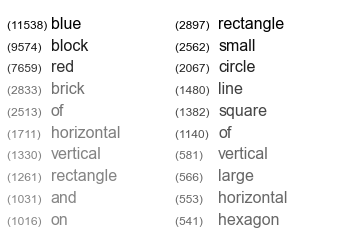

In [50]:
X_OFFSET_START = 0
Y_OFFSET_START = 1

X_OFFSET_INTERVAL = 0.5
Y_OFFSET_INTERVAL = 0.1

X_OFFSET_WORD = 0.13

cmap = matplotlib.cm.get_cmap("Greys")

fig = plt.figure()

x_offset = X_OFFSET_START
for domain in domains:
    
    y_offset = Y_OFFSET_START

#     plt.text(x_offset, y_offset, domain, fontweight="bold", color=cmap(1.0))
    y_offset -= Y_OFFSET_INTERVAL
    
    domain_counts = np.array([b for (a, b) in top_words_domain[domain]])
    
    norm = matplotlib.colors.Normalize(vmin=min(-(domain_counts.mean()*3), domain_counts.min()), vmax=domain_counts.max())
    
    for word, count in top_words_domain[domain]:
        alpha = 1
        plt.text(x_offset, y_offset, f"({count:.0f}) ", color=cmap(norm(count)), fontsize=12, alpha=alpha, fontname="Arial")
        plt.text(x_offset + X_OFFSET_WORD, y_offset, word, color=cmap(norm(count)), fontsize=16, alpha=alpha)
        
        y_offset -= Y_OFFSET_INTERVAL
    
    x_offset += X_OFFSET_INTERVAL
    
plt.grid(False)
plt.axis("off")
plt.show()

fig.savefig(f"top_words.pdf", bbox_inches="tight")


### Pointwise Mutual Information (PMI)

#### Most diagnostic words of subdomain (PMI)

In [40]:
DOMAIN = "structures"
# DOMAIN = "drawing"

df_domain = df_trial[(df_trial.domain == DOMAIN) & (df_trial.complete_dataset) & (~df_trial.ppt_hit_8_step_limit) & (df_trial.stimId != 'demo_stim')]
df_domain = df_domain.reset_index(drop=True)

df_domain["lemmatized_whats_flat"] = df_domain["lemmatized_whats"].map(lambda whats_list: " ".join([spelling_map[item] for sublist in whats_list for item in sublist if word_to_pos[item] == "NOUN"]))

# df_domain

In [41]:
vectorizer = CountVectorizer(strip_accents="unicode", min_df=5, stop_words="english")
X = vectorizer.fit_transform(df_domain["lemmatized_whats_flat"])

df_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

PSEUDOCOUNT = 1 / len(df_counts.columns)

df_counts = df_counts + PSEUDOCOUNT
# df_counts

In [42]:
d_pmi = defaultdict(dict)

N = df_counts.sum().sum()
JOINT_EXP = 1

subdomain_priors = ((df_domain.subdomain.value_counts()) / len(df_domain)).to_dict()

for subdomain in subdomain_priors:
    p_subdomain = np.log2(subdomain_priors[subdomain])
    for word in df_counts.columns:
        p_joint = np.log2((df_counts[word][df_domain.subdomain == subdomain].sum()) / N)
        p_word = np.log2((df_counts[word].sum()) / N)
                
        pmi = p_joint - (p_word + p_subdomain)
        d_pmi[subdomain][word] = pmi

In [43]:
# Percentage of positive PMI values
df_pmi = pd.DataFrame(d_pmi)
(df_pmi > 0).sum().sum() / (df_pmi != 0).sum().sum()

0.3625

In [47]:
# pd.DataFrame({subdomain: df_pmi[subdomain].nlargest(30).index.tolist() for subdomain in subdomain_priors})

In [45]:
# reorder columns
df_pmi = df_pmi[subdomains[DOMAIN]]

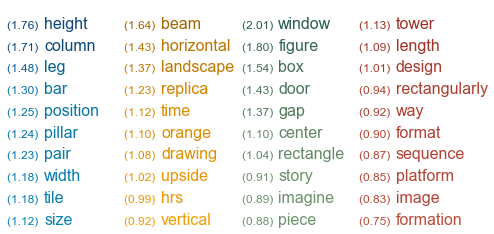

In [46]:
TOP_N = 10

X_OFFSET_START = 0
Y_OFFSET_START = 1

X_OFFSET_INTERVAL = 0.35
Y_OFFSET_INTERVAL = 0.1

X_OFFSET_WORD = 0.11

# CMAPS = map(matplotlib.cm.get_cmap, ["Blues", "Oranges", "Greens", "Reds"])
CMAPS = gradients


fig = plt.figure()

x_offset = X_OFFSET_START
for subdomain, cmap in zip(df_pmi.columns, CMAPS):
    df_pmi_subdomain_top = df_pmi[subdomain].nlargest(TOP_N)
    
    y_offset = Y_OFFSET_START

#     plt.text(x_offset, y_offset, subdomain, fontweight="bold", color=cmap(1.0), fontname="Arial")
    y_offset -= Y_OFFSET_INTERVAL
    
    norm = matplotlib.colors.Normalize(vmin=min(0, df_pmi_subdomain_top.min()), vmax=df_pmi_subdomain_top.max())
    
    for word, pmi in df_pmi_subdomain_top.iteritems():
        alpha = int(pmi > 0)
        plt.text(x_offset, y_offset, f"({pmi:.2f}) ", color=cmap(norm(pmi)), fontsize=12, alpha=alpha, fontname="Arial")
        plt.text(x_offset + X_OFFSET_WORD, y_offset, word, color=cmap(norm(pmi)), fontsize=16, alpha=alpha)
        
        y_offset -= Y_OFFSET_INTERVAL
    
    x_offset += X_OFFSET_INTERVAL
    
plt.grid(False)
plt.axis("off")
plt.show()

fig.savefig(f"pmi_{DOMAIN}.pdf", bbox_inches="tight")

### Jenson-Shannon Distance (JSD)

#### Compare distributions of words across domain/ subdomains (JSD)

In [56]:
USE_COUNTS = True

In [57]:
trial_whats = df_trial.groupby(['gameID','trial_num'])['lemmatized_filtered_whats'].apply(lambda trial_responses: \
    ([x for xs in [word for sublist in trial_responses for word in sublist] for x in xs]))
trial_whats_counts = trial_whats.apply(lambda x: Counter(x))

df_trial_whats = df_trial[['gameID','trial_num','subdomain', 'domain','lemmatized_filtered_whats']].groupby(['gameID','trial_num']).first()
df_trial_whats.loc[:,'trial_whats'] = trial_whats
df_trial_whats.loc[:,'what_counts'] = trial_whats_counts

all_words = np.unique([x for xs in trial_whats for x in xs])

In [58]:
for w in all_words:
    if USE_COUNTS:
        df_trial_whats[w] = df_trial_whats['what_counts'].apply(lambda row: int(row[w])) # word counts
    else:
        df_trial_whats[w] = df_trial_whats['trial_whats'].apply(lambda row: int(w in row)) # present/absent
        
df_trial_whats = df_trial_whats.reset_index()

<ipython-input-58-9be1c265389d>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trial_whats[w] = df_trial_whats['what_counts'].apply(lambda row: int(row[w])) # word counts


#### Between subdomains

In [59]:
domain = 'drawing'

In [60]:
# Calculate true mean JSD
# One domain at a time
df_trial_whats_domain = df_trial_whats.loc[(df_trial_whats['domain'] == domain)].reset_index(drop=True).copy()

subdomain_counts = {}
subdomain_jsds = {}

# get counts
for subdomain in subdomains[domain]:
    subdomain_counts[subdomain] = df_trial_whats_domain.loc[(df_trial_whats['subdomain'] == subdomain)]\
                                    .iloc[:,10:].sum(axis=0)

# get JSDS
for subdomain_i in subdomains[domain]:
    subdomain_jsds[subdomain_i] = {}
    for subdomain_j in subdomains[domain]:
        subdomain_jsds[subdomain_i][subdomain_j] = distance.jensenshannon(subdomain_counts[subdomain_i],
                                                                          subdomain_counts[subdomain_j], 2)
        

true_subdomain_jsds = pd.DataFrame.from_dict(subdomain_jsds)
true_subdomain_jsds

,nuts-bolts,wheels,dials,furniture
nuts-bolts,0.000000,0.448378,0.436351,0.446686
wheels,0.448378,0.000000,0.443428,0.449511
dials,0.436351,0.443428,0.000000,0.410200
furniture,0.446686,0.449511,0.410200,0.000000


In [61]:
# get true mean JSD
true_mean_jsd = np.array(true_subdomain_jsds)[np.triu_indices(4,k = 1)].mean()
true_mean_jsd

0.439092234752765

In [68]:
# Calculate null distribution of mean JSDs

df_trial_whats_domain = df_trial_whats.loc[(df_trial_whats['domain'] == domain)].reset_index(drop=True).copy()

mean_jsds = []

n_iters = 1000

# calculate true split of trials into domains
subdomain_assignments = df_trial_whats_domain.subdomain.copy()

np.random.seed(RANDOM_SEED)

for n in range(0,n_iters):
    
    np.random.shuffle(subdomain_assignments)

    subdomain_counts = {}
    subdomain_jsds = {}

    # get counts
    for subdomain in subdomains[domain]:
        subdomain_counts[subdomain] = df_trial_whats_domain.iloc[:,10:][subdomain_assignments == subdomain]\
                                        .sum(axis=0)

    # get JSDS
    for subdomain_i in subdomains[domain]:
        subdomain_jsds[subdomain_i] = {}
        for subdomain_j in subdomains[domain]:
            subdomain_jsds[subdomain_i][subdomain_j] = distance.jensenshannon(subdomain_counts[subdomain_i],
                                                                              subdomain_counts[subdomain_j], 2)


    subdomain_jsds = pd.DataFrame.from_dict(subdomain_jsds)
    mean_jsd = np.array(subdomain_jsds)[np.triu_indices(4,k = 1)].mean()
    mean_jsds.append(mean_jsd)

(array([  5.,  22.,  70., 144., 229., 242., 160.,  89.,  28.,  11.]),
 array([0.2124121 , 0.21448602, 0.21655995, 0.21863387, 0.22070779,
        0.22278171, 0.22485563, 0.22692955, 0.22900347, 0.2310774 ,
        0.23315132]),
 <BarContainer object of 10 artists>)

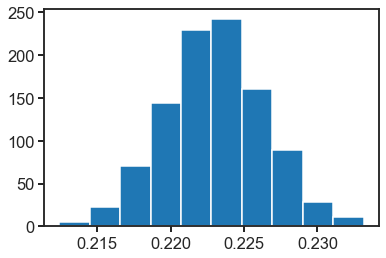

In [69]:
plt.hist(mean_jsds)

In [70]:
# Report p-value. (how many are greater than true JSD)
(sum(mean_jsds > true_mean_jsd) / n_iters) * 2

0.0

# Part II

# Additional analyses/ plots not reported in paper

### Characterizing language use

#### Number of steps in instructions

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_trial, 
             x="n_steps", 
             hue="domain",
             hue_order=['drawing','structures'],
             binwidth=1,
             stat='proportion')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps in instructions')
# plt.savefig('./plots/instruction_steps_dist.pdf')

In [ ]:
d_steps = df_trial[df_trial.domain=='drawing']['n_steps']
s_steps = df_trial[df_trial.domain=='structures']['n_steps']

stats.ttest_ind(d_steps,s_steps)

In [ ]:
## over time
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.complete_dataset)], 
             x='trial_num',
             y='n_steps', 
             hue='domain')
plt.ylim((1,11))
plt.title('total characters across trials, by domain')

#### Character count

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_trial, 
             x="what_char_sum", 
             hue="domain",
             hue_order=['drawing','structures'],
             binwidth=20,
             stat='proportion')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters in instructions')
# plt.savefig('./plots/instruction_chars_dist.pdf')

In [ ]:
d_chars = df_trial[df_trial.domain=='drawing']['char_sum']
s_chars = df_trial[df_trial.domain=='structures']['char_sum']

stats.ttest_ind(d_chars,s_chars)

In [ ]:
## over time
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.complete_dataset)], 
             x='trial_num', 
             y='char_sum', 
             hue='domain')
# plt.ylim((0,275))
plt.title('total characters across trials, by domain')


In [ ]:
# over time
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num', 
             y='char_sum', 
             hue='subdomain')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters across trials, by subdomain')

In [ ]:
## over time
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.complete_dataset)], 
             x='trial_num', 
             y='what_char_sum', 
             hue='domain')
# plt.ylim((0,275))
plt.title('total WHAT characters across trials, by domain')


In [ ]:
# over time
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num', 
             y='what_char_sum', 
             hue='subdomain')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total WHAT characters across trials, by subdomain')

In [ ]:
plt.figure(figsize=(10,6))

sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num',
             y='what_char_sum', 
             hue='domain', 
             linestyle='--')

sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num', y='where_char_sum', 
             hue='domain', 
             linestyle='-', 
             legend=False)
plt.title('total characters across trials, WHAT vs. WHERE, by domain')

### Word-based measures

In [ ]:
## over time

plt.figure(figsize=(4,6))
sns.barplot(data=df_trial[(df_trial.complete_dataset)], 
             x='domain', 
             y='n_whats_filtered')
plt.ylabel('unique what words')
# plt.ylim((0,275))
plt.title('number of unique words used per response')
# plt.savefig('./plots/unique_whats_domain.pdf')

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_trial, 
             x="n_whats_filtered", 
             hue="domain",
             hue_order=['drawing','structures'],
             binwidth=1,
             stat='proportion')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps in instructions')
# plt.savefig('./plots/instruction_steps_dist.pdf')

In [ ]:
d_whats_filtered = df_trial[df_trial.domain=='drawing']['n_whats_filtered']
s_whats_filtered = df_trial[df_trial.domain=='structures']['n_whats_filtered']

stats.ttest_ind(d_whats_filtered,s_whats_filtered)

In [ ]:
s_whats_filtered.mean()

In [ ]:
d_whats_filtered.mean()

In [ ]:
## over time

plt.figure(figsize=(4,6))
sns.barplot(data=df_trial[(df_trial.complete_dataset)], 
             x='domain', 
             y='n_unique_whats')
plt.ylabel('unique what words')
# plt.ylim((0,275))
plt.title('number of unique words used per response')
# plt.savefig('./plots/unique_whats_domain.pdf')

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_trial, 
             x="n_unique_whats", 
             hue="domain",
             hue_order=['drawing','structures'],
             binwidth=1,
             stat='proportion')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps in instructions')
# plt.savefig('./plots/instruction_steps_dist.pdf')

In [ ]:
d_unique_whats = df_trial[df_trial.domain=='drawing']['n_unique_whats']
s_unique_whats = df_trial[df_trial.domain=='structures']['n_unique_whats']

stats.ttest_ind(d_unique_whats,s_unique_whats)

In [ ]:
## over time
plt.figure(figsize=(6,6))
sns.barplot(data=df_trial[(df_trial.complete_dataset)], 
             x='subdomain', 
             y='n_unique_whats',
             hue='domain')
plt.ylabel('unique what words')
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.ylim((0,275))
plt.title('number of unique words used per response')
# plt.savefig('./plots/unique_whats_subdomain.pdf')

In [ ]:
## over time

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.complete_dataset)], 
             x='trial_num', 
             y='n_unique_whats', 
             hue='domain')
# plt.ylim((0,275))
plt.title('number of unique words used per response, over time')

#### Comparisons between subdomains

In [ ]:
plt.figure(figsize=(4,8))


sns.barplot(
            data = df_trial,
            x = 'subdomain',
            order = subdomains['drawing'] +  subdomains['structures'],
            palette= {**domain_palettes['drawing'],**domain_palettes_light['structures']},
            y = 'what_word_sum')
_ = plt.xticks(rotation = 60)
# plt.savefig('./plots/what_word_sum_subdomains.pdf')

In [ ]:
plt.figure(figsize=(8,6))

sns.violinplot(
    data = df_trial,
    x = 'subdomain',
    order = subdomains['drawing'] +  subdomains['structures'],
    y = 'what_word_sum',
    palette= {**domain_palettes['drawing'],**domain_palettes_light['structures']},
    linewidth=2)

In [ ]:
f = plt.figure(figsize=(8,6))

sns.violinplot(
    data = df_trial.groupby(['domain','subdomain','stimId']).first().reset_index(),
    x = 'subdomain',
    order = subdomains['drawing'] +  subdomains['structures'],
    palette = {**domain_palettes['drawing'],**domain_palettes_light['structures']},
    y = 'what_word_mean',
    linewidth=2)

### Word counts

token-based length: across domains, across subdomains within domain, across stims within subdomain, across participants

In [ ]:
sns.histplot(data = df_trial, x="what_word_sum", log_scale=True, fill=False, element="step")
sns.histplot(data = df_trial, x="where_word_sum", log_scale=True, fill=False, element="step")

In [ ]:
sns.histplot(data = df_trial,
             x="what_word_sum", 
             hue='domain',
             stat="density",
             common_norm=False,
             log_scale=True,
             fill=False,
             element="step")

In [ ]:
# mean word count (across participants) for each subdomain
plt.figure(figsize=(4,6))

sns.barplot(data=what_word_sum_means,
            x='domain',
            y='what_word_mean',
            hue_order=['structures','drawing']
           )
plt.xticks(rotation = 45)
plt.ylabel('what words')
plt.title('word count by domain')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.subplots_adjust(left=0.2, bottom=0.35)
# plt.savefig('./plots/what_word_count_domain.pdf')

In [ ]:
# mean word count (across participants) for each subdomain
plt.figure(figsize=(6,6))

sns.barplot(data=what_word_sum_means,
            x='subdomain',
            hue='domain',
            y='what_word_mean',
            hue_order=['drawing','structures']
           )
plt.xticks(rotation = 45)
plt.ylabel('what words')
plt.title('word count by subdomain')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.subplots_adjust(left=0.2, bottom=0.35)
# plt.savefig('./plots/what_word_count_subdomain.pdf')

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_trial[df_trial.subdomain.isin(['nuts-bolts','dials'])], 
             x="what_word_mean", 
             hue="subdomain",
#              hue_order=['drawing','structures'],
             binwidth=5,
             stat='proportion')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('mean number of words in instructions')
# plt.savefig('./plots/instruction_chars_dist.pdf')

## utils

### merge urls with top down abstraction dataframe

In [ ]:
urls = df_trial[df_trial.domain=='structures'].groupby(['stimId','stimURL','subdomain']).first().reset_index()[['blocks','stimId','stimURL','domain','subdomain']]
urls

In [ ]:
df_topdownabs = pd.read_csv('../../stimuli/towers/df_structures_topdownabs_consistent_abstractions.csv')

In [ ]:
df_topdownabs['stimId'] = df_topdownabs['structure_number']
df_topdownabs['subdomain'] = df_topdownabs['structure_type']

In [ ]:
df_topdownabs.merge(urls, how='left',on=['blocks','stimId','subdomain'])

In [ ]:
df_topdownabs.to_csv('../../stimuli/towers/df_structures_topdownabs_consistent_abstractions.csv')